## Machine Learning Steps
### 1. Modeling the data 
### 2. Errors
### 3. Optimizer

### Complete pipeline : EDA - Statistical Analysis - Logistic Regression Model

###### This data set dates from 1988 and consists of four databases: Cleveland, Hungary, Switzerland, and Long Beach V. It contains 76 attributes, including the predicted attribute, but all published experiments refer to using a subset of 14 of them. The "target" field refers to the presence of heart disease in the patient. It is integer valued 0 = no disease and 1 = disease (https://archive.ics.uci.edu/dataset/45/heart+disease%C2%B6)

#### Load necessary packages

In [132]:
#LOGISTIC REGRESSION MODEL 
#Find a logistic regresion model to predict the probability of the presence (target = 1) of heart disease, or not (target = 0). 
#Take the following variables for the model: sex (binary, F = 0, M = 1), age (integer, continous), chol (continous), blood pressure (trestbps, continous), and chest paint type (cp, categorical, 1 - 4)
# Librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

#### Load and explore the dataset

In [133]:
#Load the dataset: https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset 
filepath = r"C:\Users\ksenia\Desktop\PythonProject\Heart.csv"
df = pd.read_csv(filepath)

In [134]:
print(df.head(3)) # Print first three lines of the dataset

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  


In [135]:
print(df.info()) # Information about variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB
None


In [136]:
print(df.isnull().sum()) # Number of missing values

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


In [137]:
print(df['target'].value_counts()) #Numer of targets of each category

target
1    526
0    499
Name: count, dtype: int64


###### Two categories are balanced

In [138]:
#Keep only the columns of interest
cols = ['sex', 'age', 'chol', 'trestbps', 'cp', 'target']
df = df[cols]

#### 1. Exploratry data analysis

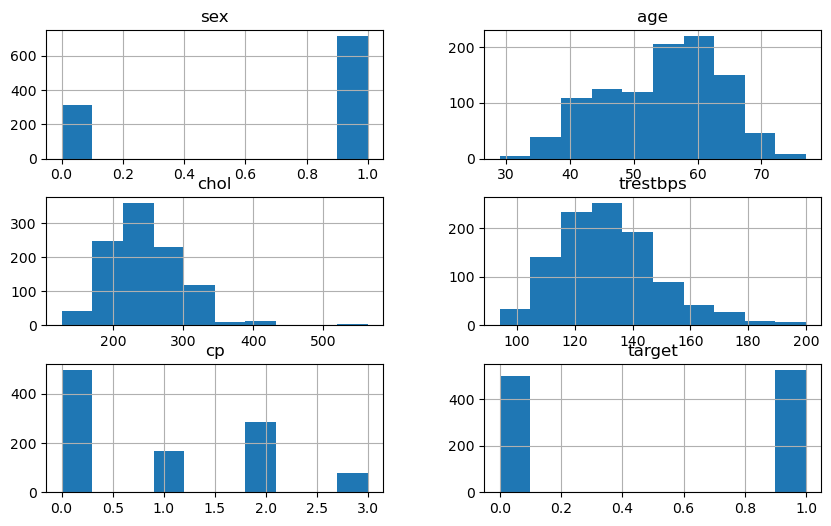

In [145]:
# Histogrammes
df.hist(figsize=(10,6))
plt.show()

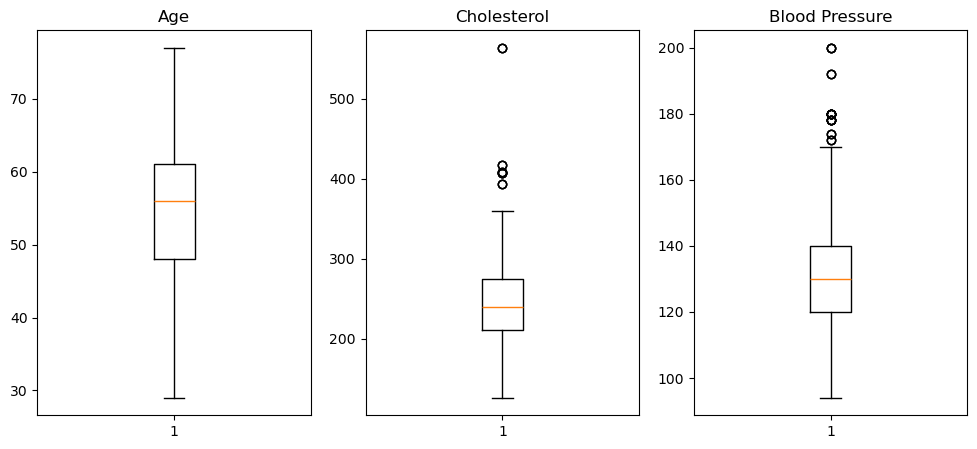

In [144]:
# Boxplots
plt.figure(figsize=(12,5))
plt.subplot(1,3,1); plt.boxplot(df['age']); plt.title("Age")
plt.subplot(1,3,2); plt.boxplot(df['chol']); plt.title("Cholesterol")
plt.subplot(1,3,3); plt.boxplot(df['trestbps']); plt.title("Blood Pressure")
plt.show()

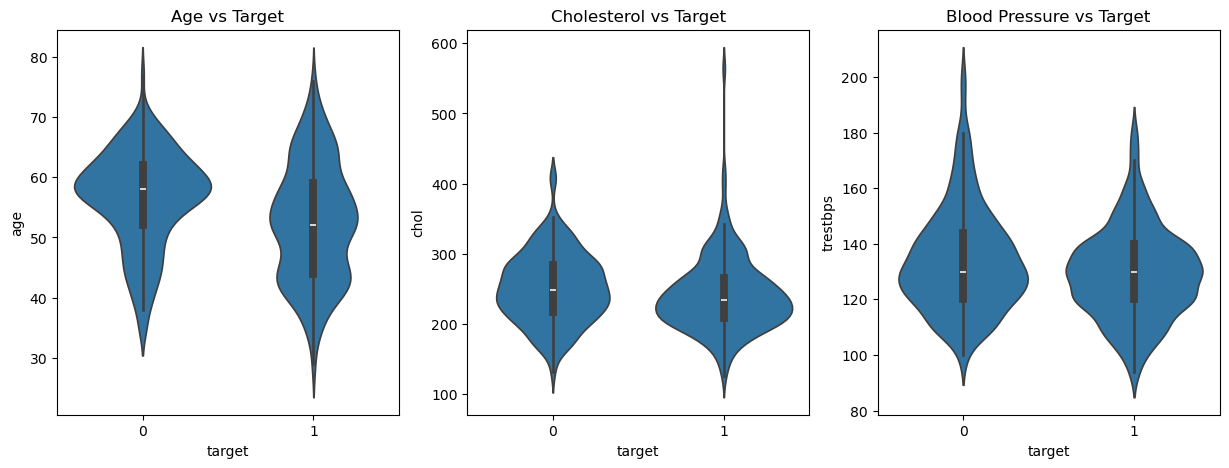

In [143]:
# Violin plots (per target)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); sns.violinplot(x='target', y='age', data=df); plt.title("Age vs Target")
plt.subplot(1,3,2); sns.violinplot(x='target', y='chol', data=df); plt.title("Cholesterol vs Target")
plt.subplot(1,3,3); sns.violinplot(x='target', y='trestbps', data=df); plt.title("Blood Pressure vs Target")
plt.show()

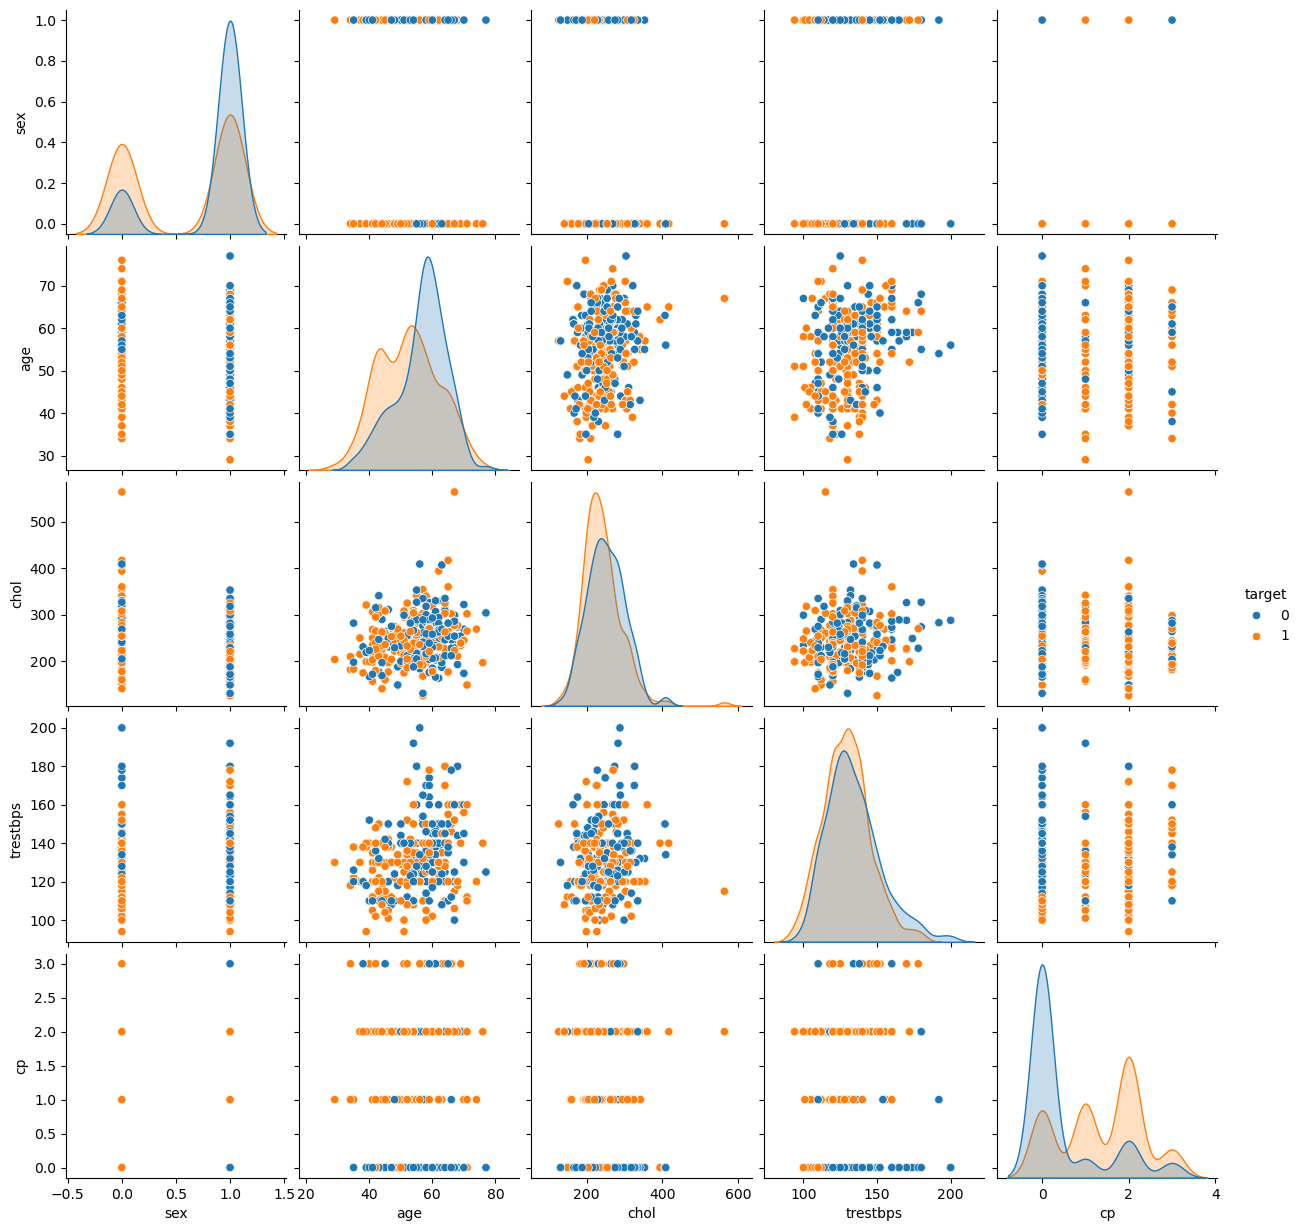

In [142]:
# Pairplot
sns.pairplot(df, hue='target')
plt.show()

#### 2. Statistical analyses

In [146]:
# Normality test (Shapiro-Wilk) for the continous variables
for col in ['age', 'chol', 'trestbps']:
    stat, p = shapiro(df[col])
    print(f"{col} - Stat={stat:.3f}, p={p:.3f} -> {'Normal' if p>0.05 else 'Non-normal'}")

age - Stat=0.984, p=0.000 -> Non-normal
chol - Stat=0.950, p=0.000 -> Non-normal
trestbps - Stat=0.963, p=0.000 -> Non-normal


In [147]:
# Compare the means (t-test or Mann-Whitney depending on normality)
# Non-normal distribution, so use Mann-Whitney
from scipy.stats import mannwhitneyu

# Compare the distributions using Mann-Whitney U test
for col in ['age', 'chol', 'trestbps']:
    group0 = df[df['target']==0][col]
    group1 = df[df['target']==1][col]
    stat, p = mannwhitneyu(group0, group1, alternative='two-sided')
    significance = "statistically significant difference" if p < 0.05 else "no significant difference"
    print(f"{col} - Mann-Whitney U test p={p:.3f} -> {significance}")

age - Mann-Whitney U test p=0.000 -> statistically significant difference
chol - Mann-Whitney U test p=0.000 -> statistically significant difference
trestbps - Mann-Whitney U test p=0.000 -> statistically significant difference


#### 3. Modeling Logistic Regression

##### Feature and Target dataset preparation

In [181]:
# Data Preparation for the Model
X = df[['sex', 'age', 'chol', 'trestbps', 'cp']]
y = df['target']

##### One-hot encoding for categorical variable

In [182]:
# One-hot encoding for cp (categorical) 
# cp (chest pain type) is a categorical variable with values 0, 1, 2, 3
# Machine learning models, like logistic regression, require numerical input. 
# You cannot just give it 1, 2, 3, 4 because the model might assume that 3 > 2 > 1 > 0 implies an order, which is not correct for categories.
# Solution: Convert categories into binary columns (one-hot encoding).
from sklearn.preprocessing import OneHotEncoder
# Select the column with categrical value
categorical_column = ['cp']
# Create the encoder
encoder = OneHotEncoder(drop='first', sparse_output=False, dtype=int)
#Apply the encoder to the column
cp_encoded = encoder.fit_transform(X[categorical_column])
# Names of the new columns
encoded_cols = encoder.get_feature_names_out(categorical_column)
# Convert to DataFrame
cp_encoded_df = pd.DataFrame(cp_encoded, columns=encoded_cols, index=X.index)
# Replace by new columns
X = X.drop(columns=categorical_column)  # supprimer la colonne originale
X = pd.concat([X, cp_encoded_df], axis=1)
# Display all column names
print(X)

      sex  age  chol  trestbps  cp_1  cp_2  cp_3
0       1   52   212       125     0     0     0
1       1   53   203       140     0     0     0
2       1   70   174       145     0     0     0
3       1   61   203       148     0     0     0
4       0   62   294       138     0     0     0
...   ...  ...   ...       ...   ...   ...   ...
1020    1   59   221       140     1     0     0
1021    1   60   258       125     0     0     0
1022    1   47   275       110     0     0     0
1023    0   50   254       110     0     0     0
1024    1   54   188       120     0     0     0

[1025 rows x 7 columns]


##### Scaler 

In [183]:
# Standardization ==> it is better to standartize when data have many outliers
# scaler = StandardScaler()
# X[['age', 'chol', 'trestbps']] = scaler.fit_transform(X[['age', 'chol', 'trestbps']])
#  But here, we will use another technique 
# MinMaxScaler ==> to rescale my data from the range like (0, 1) or (-1, 1) : x new = (x - x min)/(x max - x min)
# It is ok for my dataset 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X[['age', 'chol', 'trestbps']] = scaler.fit_transform(X[['age', 'chol', 'trestbps']])

##### Split the data into Training, Validation and Test sets

In [184]:
# First split: Train + Validation (80%) + Test (20%)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Second split: From the 80%, split again into: Train (60%) + Validation (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, 
    test_size=0.25,  # 0.25 of 80% = 20% of total
    random_state=42,
    stratify=y_train_full)

# SAVE YOUR DATASETS IN A DISK !!!

print("Train / Validation / Test set class distribution:")
print(y_train.value_counts(), y_val.value_counts(), y_test.value_counts())

Train / Validation / Test set class distribution:
target
1    316
0    299
Name: count, dtype: int64 target
1    105
0    100
Name: count, dtype: int64 target
1    105
0    100
Name: count, dtype: int64


##### Some statictis to describe the continous variables

In [152]:
X_train[['age', 'chol', 'trestbps']].describe()

,age,chol,trestbps
count,615.000000,615.000000,615.000000
mean,0.536450,0.278843,0.367694
std,0.187412,0.121691,0.170403
min,0.000000,0.000000,0.000000
25%,0.416667,0.196347,0.245283
50%,0.562500,0.260274,0.339623
75%,0.666667,0.356164,0.433962
max,1.000000,1.000000,1.000000


##### Modeling Logstic Regression

In [185]:
%%time
# Modeling: Logistic Regression
model = LogisticRegression(solver='liblinear') # you can try other solvers, change number of iterations, verbose etc...
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_train) # Predicted y using training features
y_prob = model.predict_proba(X_train)[:,1] # The predicted probability of being class 1

print('Features :', ' ', list(X.columns))
print('Weights :', ' ', model.coef_.tolist()) # weights
print('Intercept :', ' ', model.intercept_)

Features :   ['sex', 'age', 'chol', 'trestbps', 'cp_1', 'cp_2', 'cp_3']
Weights :   [[-1.5476842274195362, -1.890642621976132, -0.7394277563094241, -1.15120510882696, 2.3458810802041805, 2.359549633977979, 2.30453996184471]]
Intercept :   [1.59326926]
CPU times: total: 15.6 ms
Wall time: 18.4 ms


##### Weight of each feature

<Axes: xlabel='Weight', ylabel='Feature'>

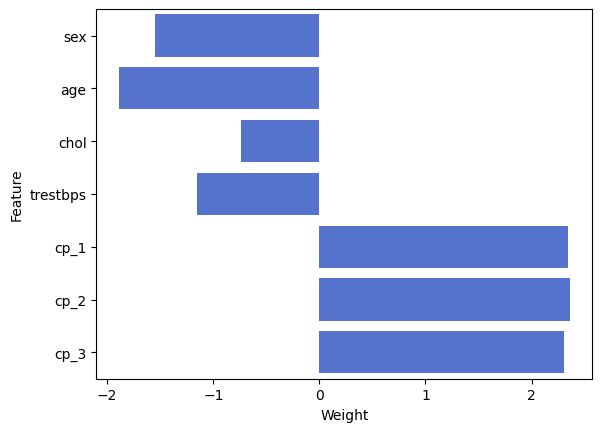

In [186]:
weight_df = pd.DataFrame({'Feature': X_train.columns, 'Weight': model.coef_.tolist()[0]})
sns.barplot(data=weight_df, x='Weight', y='Feature', color = 'royalblue')

##### Evaluation of the model

In [155]:
# Evaluation
# Accuracy score (Num of correct predictions/Total Num of predctions) 
print('Accuracy Score:')
print(accuracy_score(y_train, y_pred))
# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_pred, normalize='true'))
# Classification report
print("\nClassification Report:")
print(classification_report(y_train, y_pred)) 

Accuracy Score:
0.7821138211382114
Confusion Matrix:
[[0.75919732 0.24080268]
 [0.19620253 0.80379747]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.76      0.77       299
           1       0.78      0.80      0.79       316

    accuracy                           0.78       615
   macro avg       0.78      0.78      0.78       615
weighted avg       0.78      0.78      0.78       615



#### Class 0 explanation
###### Precision : when the model predicts no disease, it's correct 78% of the time
###### Recall : out of all real healthy people (no disease), the model correctly identifies 73% of them
###### F1 Score : harmonic mean of Precision and Recall (forces both values to be high)
###### Support : the number of actual occurrences of each class (0, 1) in the test set
#### Class 1 explanation
###### Precision : when the model predicts disease, it is correct 76% of the time
###### Recall : out of all real disease patients, the model detects 80% of them

##### ROC/AUC curve

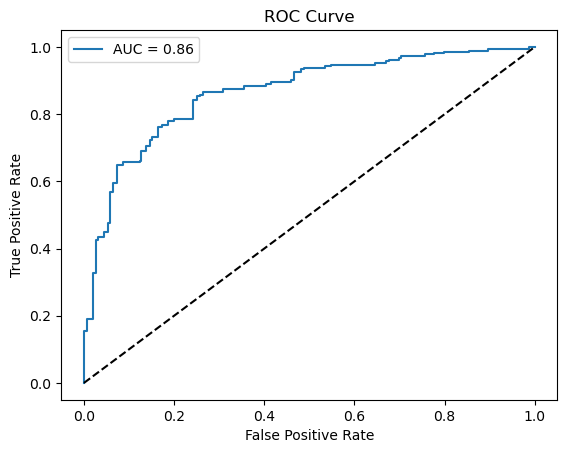

In [156]:
# ROC / AUC
auc = roc_auc_score(y_train, y_prob)
fpr, tpr, thresholds = roc_curve(y_train, y_prob)
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

###### ROC : Receiver Operating Characteristic
###### The ROC curve is a graphical way to evaluate a binary classifier
###### The curve plots : x axis is False Positive Rate (FP/(FP + TN)) and y axis is True Positive Rate (TP/(TP + FN))
###### AUC : Area Under the Curve
###### The AUC measures the area under the ROC curve
###### Higher AUC means the model is better at distinguishing between the positive class (1) and negative class (0)
###### AUC -> 1 ==> perfect distinguishing between classes

#### Confusion Matrix for Validation and Test sets

In [157]:
# Predictions
# Validation Set 
y_pred_val = model.predict(X_val) # Predicted y using training features
# Confusion Matrix Validation Set
print("Confusion Matrix for Validation Set")
print(confusion_matrix(y_val, y_pred_val, normalize='true'))
print(' ')
# Test Set
y_pred_test = model.predict(X_test)
print("Confusion Matrix for Test Set")
print(confusion_matrix(y_test, y_pred_test, normalize='true'))

Confusion Matrix for Validation Set
[[0.73       0.27      ]
 [0.19047619 0.80952381]]
 
Confusion Matrix for Test Set
[[0.7        0.3       ]
 [0.23809524 0.76190476]]


#### Compare the obtained Model with Random Models

In [129]:
# Random choice between 0 and 1
def random_guess(input):
    return np.random.choice([0, 1], len(input)) 
accuracy_score(y_test, random_guess(X_test))

0.5365853658536586

###### The random model gives about 50% of chance to predict 0/1

In [130]:
# The model that returns always 0
def all_no(input):
    return np.full(len(input), 0)
accuracy_score(y_test, random_guess(X_test))

0.44878048780487806

#### Create a function to apply the obtained Model

In [190]:
# Function to predict cardiovascular disease
def predict_patient(patient_dict, model, scaler, encoder):
    """
    Predict cardiovascular disease (0/1 : no/yes) for a patient.

    Parameters:
        patient_dict (dict): 
            {'sex': 0/1, 'age': int, 'chol': int, 'trestbps': int, 'cp': 0-3}
            sex is binary: 0 = female, 1 = male
        model: trained LogisticRegression model
        scaler: fitted MinMaxScaler for numeric features
        encoder: fitted OneHotEncoder for 'cp' categorical feature

    Returns:
        dict: {'prediction': 0/1, 'probability': float}
    """
    numeric_features = ['age', 'chol', 'trestbps']
    categorical_features = ['cp']
    binary_feature = ['sex']

    # Convert dictionary to DataFrame
    df_p = pd.DataFrame([patient_dict])

    # Use binary feature as-is
    sex_values = df_p[binary_feature].values

    # Scale numeric features
    num_scaled = scaler.transform(df_p[numeric_features])

    # One-hot encode categorical features
    cat_encoded = encoder.transform(df_p[categorical_features])

    # Combine features in correct order: sex, numeric, one-hot
    X_new = np.concatenate([sex_values, num_scaled, cat_encoded], axis=1)

    # Make prediction
    pred = model.predict(X_new)[0]
    prob = model.predict_proba(X_new)[0, 1]

    return {'prediction': int(pred), 'probability': float(prob)}

#### Exemple usage

In [195]:
# Example usage
patient = {
    "sex": 0,        # 0 : female, 1 : male
    "age": 40,
    "chol": 130,
    "trestbps": 130,
    "cp": 0
}

result = predict_patient(patient, model, scaler, encoder)
print(result)
#Example output: {'prediction': 1, 'probability': 0.78}

{'prediction': 1, 'probability': 0.6818461356454548}


C:\Users\ksenia\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\ksenia\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
